# TASK_1: TITANIC SURVIVAL PREDICTION

In [103]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [104]:
# calling the dataset
df = pd.read_csv('tested.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Exploration on the dataset

In [105]:
# dimensions
df.shape

(418, 12)

In [106]:
# datatypes
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [107]:
# checking for the Null values
100*df.isna().mean()

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

In [108]:
# checking the balance of the dataset
survival_count = df["Survived"].value_counts()
survival_rate = 100*survival_count/df.shape[0]
survival_data = pd.concat([survival_count, survival_rate], axis=1).reset_index()
survival_data.columns = ['Survived', 'Count', 'Percentage']

survival_data

,Survived,Count,Percentage
0,0,266,63.636364
1,1,152,36.363636


Text(0.5, 1.0, 'Percentage Survival of the Titanic Passengers')

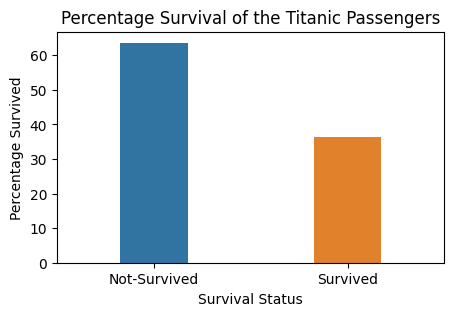

In [109]:
# plot the survival percentage
plt.figure(figsize=(5, 3))
sns.barplot(survival_data, x=['Not-Survived', 'Survived'], y='Percentage',
            width=0.35)
plt. ylabel('Percentage Survived')
plt. xlabel('Survival Status')
plt.title('Percentage Survival of the Titanic Passengers')

In [110]:
# function to show survival rate according to grps
def survival_acc_to_grp(df, colname):
    plt.figure(figsize=(5, 3))
    survival_by_pclass = df[['Survived', colname]].value_counts().reset_index()
    sns.barplot(survival_by_pclass, x=colname, y='count', hue='Survived')
    plt.ylabel('Number of Survived')
    plt.title(f'Survival According to {colname}')

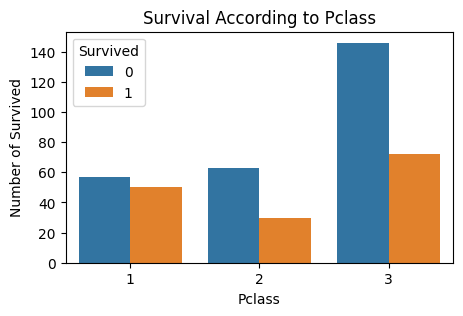

In [111]:
# survival among the Pclass
survival_acc_to_grp(df, 'Pclass')

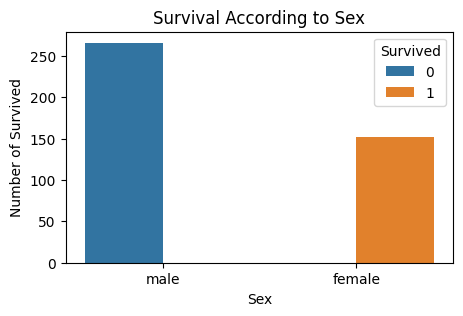

In [112]:
# survival among the Sex
survival_acc_to_grp(df, 'Sex')

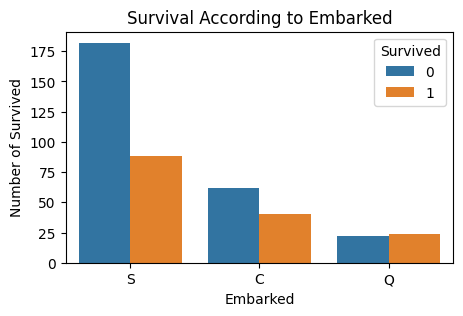

In [113]:
# survival among the Embarked
survival_acc_to_grp(df, 'Embarked')

In [114]:
# function to show distribution of variables according to survival
def vars_acc_to_surv(df, colname):
    plt.figure(figsize=(5, 3))
    sns.kdeplot(df, x=colname, hue='Survived')
    plt.title(f'{colname} distribution according to the survival')

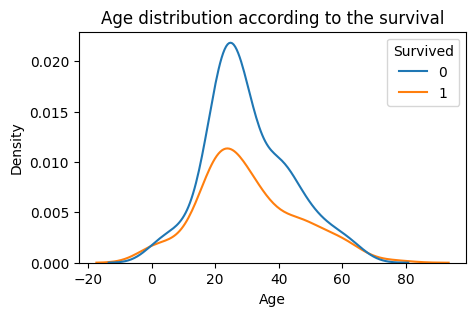

In [115]:
# age distribution according to survival status
vars_acc_to_surv(df, 'Age')

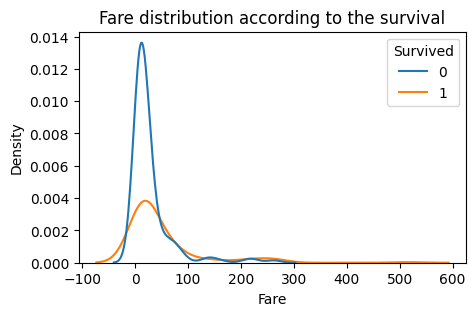

In [116]:
# fare distribution according to survival status
vars_acc_to_surv(df, 'Fare')

In [117]:
# function to visualise count data according to survival
def count_acc_to_surv(df, colname):
    plt.figure(figsize=(5, 3))
    df1 = df.groupby(['SibSp', 'Survived']).count()['PassengerId'].reset_index()
    sns.barplot(df1, x='SibSp', y='PassengerId', hue='Survived')
    plt.title(f'{colname} according to survival')
    plt.xlabel(f'{colname}')
    plt.ylabel('count')

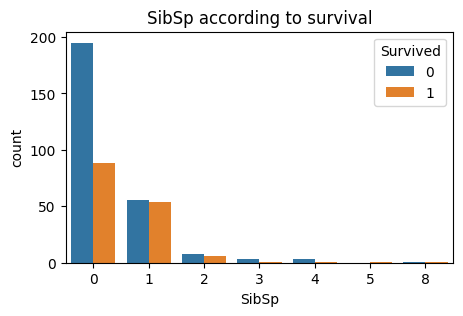

In [118]:
# SibSp distribution according to survival status
count_acc_to_surv(df, 'SibSp')

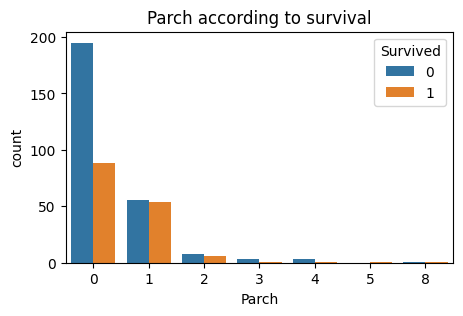

In [119]:
# Parch distribution according to survival status
count_acc_to_surv(df, 'Parch')

Text(0.5, 1.0, 'Comparison of the continuous variables')

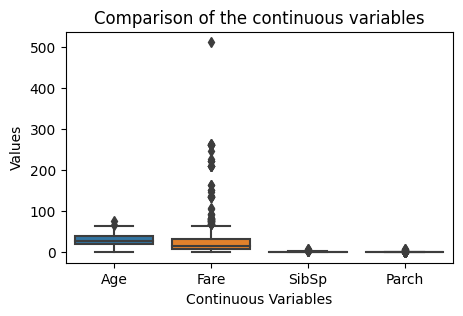

In [120]:
# variabilty and the location of the continuous variables
cont_vars = pd.melt(df, value_vars=['Age', 'Fare', 'SibSp', 'Parch'])
plt.figure(figsize=(5,3))
sns.boxplot(cont_vars, x='variable', y='value')
plt.xlabel('Continuous Variables')
plt.ylabel('Values')
plt.title('Comparison of the continuous variables')

### Data Preparation

In [121]:
# taking out the important features
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,34.5,0,0,7.8292,Q
1,1,3,female,47.0,1,0,7.0000,S
2,0,2,male,62.0,0,0,9.6875,Q
3,0,3,male,27.0,0,0,8.6625,S
4,1,3,female,22.0,1,1,12.2875,S


In [122]:
# deleting rows that has Null values in 'Fare' Column
df = df.dropna(subset='Fare')

In [123]:
# filling up the missing values of the 'Age' column by the median age
df['Age'] = df['Age'].fillna(df['Age'].median())

In [124]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [125]:
# handling imbalance
df_survived = df[df['Survived']==1]
df_not_survived = df[df['Survived']==0]

df_survived_resampled = df_survived.sample(n=df_not_survived.shape[0], replace=True, random_state=101)
df_balanced = pd.concat([df_not_survived, df_survived_resampled]).sample(frac=1, random_state=26)
df_balanced

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
195,0,3,male,33.0,0,0,7.8542,S
332,0,3,male,27.0,0,0,7.2250,C
219,0,3,male,27.0,0,0,8.0500,S
118,0,1,male,36.0,0,0,75.2417,C
382,1,3,female,27.0,0,0,14.5000,S
...,...,...,...,...,...,...,...,...
259,0,3,male,21.0,0,0,7.7750,S
128,0,2,male,42.0,0,0,13.0000,S
166,0,1,male,48.0,0,0,50.4958,C
309,1,3,female,45.0,1,0,14.1083,S


In [126]:
df_balanced['Survived'].value_counts()

Survived
0    265
1    265
Name: count, dtype: int64

In [127]:
# splitting in to X and y
X = df_balanced.drop(['Survived'], axis=1)
y = df_balanced['Survived']

In [128]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1055)

print(f'''
X_train: {X_train.shape}
X_test: {X_test.shape}
y_train: {y_train.shape}
y_test: {y_test.shape}''')


X_train: (424, 7)
X_test: (106, 7)
y_train: (424,)
y_test: (106,)


### Model Building

In [129]:
# preparing the model pipeline that includes
cont_cols = ['Age', 'Fare']
disc_cols = ['SibSp', 'Parch']
cat_cols = ['Pclass', 'Sex', 'Embarked']

continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

discrete_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, cont_cols),
        ('disc', discrete_transformer, disc_cols),
        ('cat', categorical_transformer, cat_cols)])

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('disc',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', LogisticRegression())])

In [130]:
# prediction
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0], dtype=int64)

In [131]:
# classification report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        48

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



Text(33.22222222222222, 0.5, 'Predicted Value')

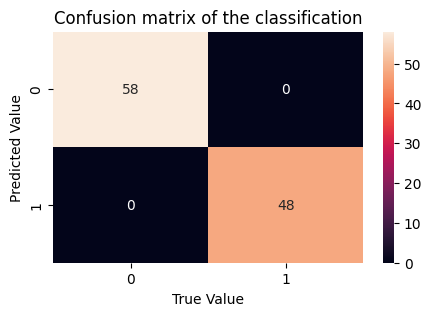

In [132]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classification')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

In [133]:
# saving the model 
with open('./model_logistic.pkl', 'wb') as fp:
    pickle.dump(model, fp)